In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0
augment = 8

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(4)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 2000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': 1.,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=0_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'],
                    augment=augment)
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.1424460513275072e-05, 'std': 0.0010204081632653184, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.0358642753165206e-05, 'std': 0.0010204081632653184, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 9.85864883296447e-06, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 8.605189334400808e-06, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 9.17628706876248e-06, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
losses=tensor([[6.7706e-04, 2.1358e-04, 1.1978e+01, 1.0914e+01]])
Elapsed time(grad):147.156
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):577.347
Fairn

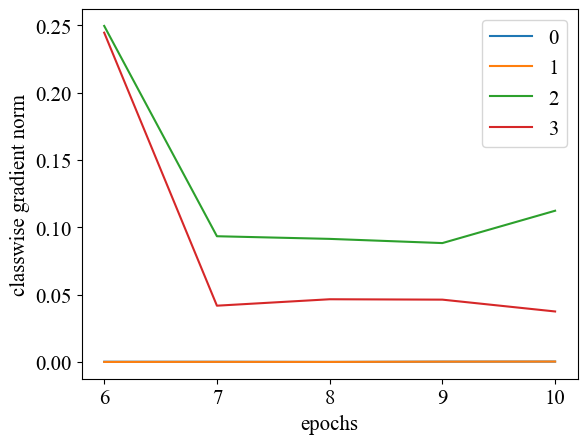

---------------------------- Task 3 -----------------------
losses=tensor([[1.1460e-03, 5.9851e-04, 1.3158e+00, 2.7292e-01, 1.2308e+01, 1.2381e+01]])
Elapsed time(grad):118.494
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):655.258
Fairness:[ 0.          0.17440331 -0.28517409  0.          0.05538516  0.05538506]
len(updated_seq_indices)=24960
Elapsed time(etc):0.433
[11] Eval metrics for task 1 >> {'accuracy': 0.9121347658005934, 'loss': 0.001348358442033718, 'std': 0.03764496988222599, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8297375086345844, 'loss': 0.0027039894044224126, 'std': 0.030727607644485344, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9586788653155909, 'loss': 0.0005035873745014471, 'std': 0.02706451553980621, 'EER': -1}
losses=tensor([[0.0019, 0.0016, 0.0012, 0.0037, 0.0633, 0.1956]])
Elapsed time(grad):107.129
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):633.07
Fairness:[ 0.       

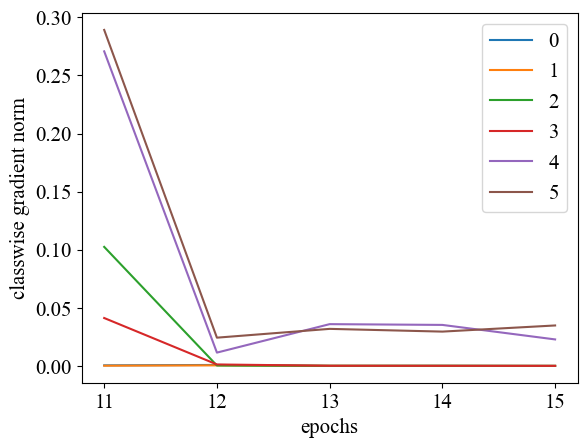

---------------------------- Task 4 -----------------------
losses=tensor([[1.6900e-04, 2.6287e-04, 4.5958e-04, 9.8608e-04, 1.6256e-01, 2.9238e-01,
         1.3750e+01, 1.1048e+01]])
Elapsed time(grad):114.631
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):1004.316
Fairness:[-5.55111512e-17  9.05052080e-02 -5.15658719e-02  0.00000000e+00
 -3.89399079e-02  0.00000000e+00  0.00000000e+00  1.27301891e-07]
len(updated_seq_indices)=29184
Elapsed time(etc):0.454
[16] Eval metrics for task 1 >> {'accuracy': 0.8561291917648117, 'loss': 0.0025835894805601584, 'std': 0.08572102849950552, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.8232922710875739, 'loss': 0.0034871714355663034, 'std': 0.007400798219356797, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.8852243979067155, 'loss': 0.0015724449395624525, 'std': 0.03432753692016843, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.9565719356961244, 'loss': 0.0005218979732807789, 'std': 0

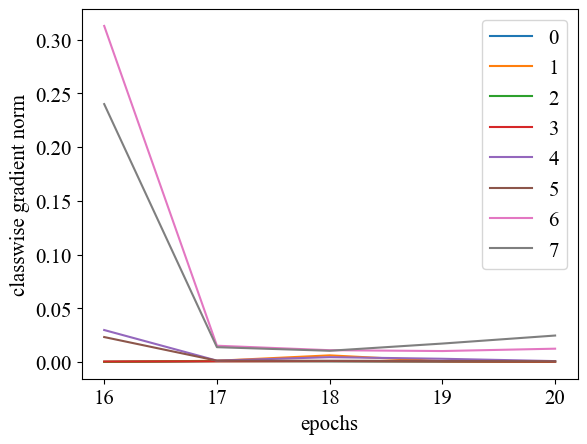

---------------------------- Task 5 -----------------------
losses=tensor([[4.8125e-04, 3.3906e-04, 9.2492e-04, 5.4978e-04, 1.2200e-03, 1.8112e-03,
         6.9283e-02, 4.2623e-02, 1.2434e+01, 1.3645e+01]])
Elapsed time(grad):106.062
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):1121.546
Fairness:[ 0.13934877  0.10070135  0.04446419  0.         -0.23591474  0.
  0.          0.         -0.0242999  -0.02429968]
len(updated_seq_indices)=30272
Elapsed time(etc):0.419
[21] Eval metrics for task 1 >> {'accuracy': 0.8284433156522522, 'loss': 0.0034512320308820576, 'std': 0.07640249932572146, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.7440123954255891, 'loss': 0.0053691304745800235, 'std': 0.012423248138767384, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.8173753116637593, 'loss': 0.0028803734985461482, 'std': 0.03598517713461136, 'EER': -1}
[21] Eval metrics for task 4 >> {'accuracy': 0.8982437471060819, 'loss': 0.0015214669470340464, 

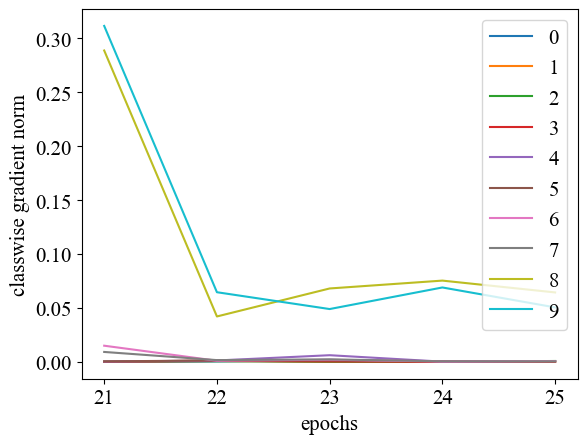

final avg-acc 0.8456224855749795
final avg-forget 0.09247401206434674


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")


642.0254	525.554	574.6543	566.2197	
2735.9724	3093.3348	4779.7643	5126.9178	
2.6043	2.1757	2.6584	2.3256	
3393.5472	3632.3834	5365.0482	5707.2503	

In [7]:
for task in range(2, 6):
    print(np.round(np.mean(list(o[task].values())), 4), end="\t")


547.1945	618.667	955.9529	1025.3836	

In [8]:
num_class_per_task = 2
num_epochs = params['epochs_per_task']

t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = dict()
    groupwise_expected_loss[i] = dict()

for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            groupwise_true_loss[i][(task-1)*num_epochs+epoch] = tl
            groupwise_expected_loss[i][(task-1)*num_epochs+epoch] = el
            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


KeyError: 1

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][ce], end='\t')
    print()


0.1235	0.0957	0.0146	0.0022	0.0018	0.0035	0.0264	0.0351	0.0134	0.0099	0.0064	0.0219	0.0158	0.0149	0.0187	0.0014	0.0342	0.0089	0.006	0.0049	
0.0605	0.0252	0.0097	0.0038	0.001	0.0006	0.0138	0.0085	0.0051	0.0052	0.0008	0.0392	0.0102	0.0128	0.0095	0.0019	0.0902	0.0191	0.0156	0.0088	
3.2977	0.8887	0.3596	0.3136	0.3079	0.1751	0.0739	0.0325	0.0099	0.0043	0.0203	0.0574	0.024	0.0106	0.007	0.0062	0.0278	0.0272	0.0147	0.008	
3.0404	0.8228	0.3535	0.2631	0.247	0.5716	0.2217	0.1454	0.0549	0.0218	0.0086	0.0494	0.0321	0.0171	0.0181	0.015	0.1285	0.0933	0.0321	0.0121	
					3.775	1.1085	0.3628	0.2461	0.2608	0.2763	0.2113	0.0393	0.0189	0.0136	0.0641	0.2541	0.1854	0.0933	0.0433	
					4.642	1.0447	0.414	0.3127	0.2801	0.5026	0.2506	0.0835	0.0299	0.0268	0.0403	0.1089	0.0529	0.0234	0.0138	
										4.506	0.7439	0.3055	0.3021	0.2783	0.2521	0.0877	0.0433	0.0194	0.0178	
										4.2374	0.9149	0.3571	0.3657	0.3068	0.3523	0.3032	0.2543	0.1455	0.1088	
															4.531	0.6211	0.2987	0.2734	0.2752	
													

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][ce], end='\t')
    print()


0.1965	0.7104	0.2392	0.3195	0.1603	0.0325	0.4976	0.4193	0.254	0.4119	-0.1554	0.0166	0.1868	0.13	0.148	-0.1152	-0.0349	0.0427	0.0216	0.018	
0.2138	0.494	0.2392	0.1597	0.1603	-0.1653	-0.0804	-0.0792	-0.0424	-0.0214	-0.1219	0.0518	0.1063	0.0841	0.1226	-0.1819	0.2666	0.2752	0.224	0.2054	
5.8942	0.7394	0.2392	0.1597	0.1603	0.2211	0.5261	0.4019	0.1771	0.1854	0.1333	0.4805	0.2934	0.2965	0.2937	-0.0999	0.1723	0.2984	0.2483	0.2689	
5.7805	0.648	0.2392	0.0	0.1603	0.4683	0.7254	0.5474	0.3689	0.3253	-0.1207	0.0766	0.1868	0.1556	0.148	-0.1034	0.227	0.3607	0.2504	0.2428	
					7.1357	0.8103	-0.0	-0.0	-0.0	0.2445	0.7213	0.3659	0.3083	0.2892	0.1329	0.5893	0.6088	0.4715	0.4491	
					9.1438	1.0803	0.2579	0.1515	0.0036	0.4854	0.6075	0.3553	0.2702	0.1827	0.0561	0.329	0.3134	0.224	0.2153	
										10.3151	0.7078	0.0	0.0	0.0	0.1394	0.2954	0.2934	0.224	0.2059	
										7.9631	0.7601	-0.0	-0.0	-0.0	0.2617	0.8444	0.7417	0.5758	0.5476	
															10.0448	0.6088	0.0	0.0	0.0	
															9.5261	0.7035	-0.

In [ ]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9146974628253304
EER:0.02548099523189896
std:0.03636128899731818
